<br>

# Assignment 2
<br>

![](https://e00-marca.uecdn.es/assets/multimedia/imagenes/2018/06/22/15296692399172.jpg)



# FIFA 2018 - Predicting the player positions through Machine Learning



I will try to train the model and predict the player's preferred position based on different features. The dataset contains all FIFA 18 players **(~18K players)** with **70+** attributes.


## Contents

* Data manipulation
* Data normalization (and why it is needed)
* Predict binary targets (attack vs defend positions) with logistic regression
* Feature selections
* Study PCA impact on model accuracy
* Study LDA impact on model accuracy
* Predict the positions with logistic regression 
* Predict the positions with random forest 
* Predict the positions with neural networks 
* Evaluate the Models 

<br>
Appreciate if you can **Upvote** if this notebook is helpful to you in some ways!


## Data manipulation

First let's import some packages:

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,roc_auc_score,auc  
#models
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score,learning_curve,GridSearchCV,validation_curve,cross_val_predict
from sklearn.linear_model import LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline 

Load the data:

In [3]:
url = 'https://raw.githubusercontent.com/13161272/Machine-Learning-2019/master/Assignment%202/CompleteDataset.csv'
df = pd.read_csv(url)
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,Preferred Positions,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,€565K,2228,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88,89.0,53.0,62.0,91.0,82.0,20801,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,ST LW,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,€565K,2154,92,48,90,95,95,96,77,89,97,95,90,6,11,15,14,8,71,22,68,87,88,13,74,93,95,88,85,26,87,73,28,59,90,85,92.0,45.0,59.0,92.0,84.0,158023,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,RW,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,€280K,2100,94,56,96,82,95,92,75,81,96,89,84,9,9,15,15,11,62,36,61,75,77,21,81,90,88,81,80,33,90,78,24,53,80,83,88.0,46.0,59.0,88.0,79.0,190871,88.0,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,LW,88.0,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,€510K,2291,88,78,86,60,91,83,77,86,86,94,84,27,25,31,33,37,77,41,69,64,86,30,85,92,93,83,87,38,77,89,45,80,84,88,87.0,58.0,65.0,88.0,80.0,176580,87.0,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,ST,87.0,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,€230K,1493,58,29,52,35,48,70,15,14,30,13,11,91,90,95,91,89,25,30,78,59,16,10,47,12,85,55,25,11,61,44,10,83,70,11,NaN,NaN,NaN,NaN,NaN,167495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check out columns:

In [4]:
df.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID',
       'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB',
       'Preferred Positions', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM',
       'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

Gather only columns that we need for this analysis purpose:

In [5]:
# GK attributes are not our interest
columns_needed = ['Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'Preferred Positions']

# attack attribute first, then defence, then mixed
columns_needed_rearranged = ['Aggression','Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'Heading accuracy', 'Long shots','Penalties', 'Shot power', 'Volleys', 
       'Short passing', 'Long passing',
       'Interceptions', 'Marking', 'Sliding tackle', 'Standing tackle',
       'Strength', 'Vision', 'Acceleration', 'Agility', 
       'Reactions', 'Stamina', 'Balance', 'Ball control','Composure','Jumping', 
       'Sprint speed', 'Positioning','Preferred Positions']

df = df[columns_needed_rearranged]
df.head()

,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,Volleys,Short passing,Long passing,Interceptions,Marking,Sliding tackle,Standing tackle,Strength,Vision,Acceleration,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,88,83,77,29,22,23,31,80,85,89,89,96,92,63,93,95,95,91,95,ST LW
1,48,77,89,97,95,90,71,88,74,85,85,88,87,22,13,26,28,59,90,92,90,95,73,95,95,96,68,87,93,RW
2,56,75,81,96,89,84,62,77,81,80,83,81,75,36,21,33,24,53,80,94,96,88,78,82,95,92,61,90,90,LW
3,78,77,86,86,94,84,77,86,85,87,88,83,64,41,30,38,45,80,84,88,86,93,89,60,91,83,69,77,92,ST
4,29,15,14,30,13,11,25,16,47,25,11,55,59,30,10,11,10,83,70,58,52,85,44,35,48,70,78,61,12,GK


We don't want to classify GK because it will be too obvious:

In [6]:
df['Preferred Positions'] = df['Preferred Positions'].str.strip()
df = df[df['Preferred Positions'] != 'GK']
df.head()



,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,Volleys,Short passing,Long passing,Interceptions,Marking,Sliding tackle,Standing tackle,Strength,Vision,Acceleration,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,88,83,77,29,22,23,31,80,85,89,89,96,92,63,93,95,95,91,95,ST LW
1,48,77,89,97,95,90,71,88,74,85,85,88,87,22,13,26,28,59,90,92,90,95,73,95,95,96,68,87,93,RW
2,56,75,81,96,89,84,62,77,81,80,83,81,75,36,21,33,24,53,80,94,96,88,78,82,95,92,61,90,90,LW
3,78,77,86,86,94,84,77,86,85,87,88,83,64,41,30,38,45,80,84,88,86,93,89,60,91,83,69,77,92,ST
5,80,62,77,85,91,84,85,83,81,88,87,83,65,39,25,19,42,84,78,79,78,91,79,80,89,87,84,83,91,ST


Check any missing data:

In [7]:
df.isnull().values.any()

False

All possible outcome for preferred position:

In [8]:
p = df['Preferred Positions'].str.split().apply(lambda x: x[0]).unique()
p

array(['ST', 'RW', 'LW', 'CDM', 'CB', 'RM', 'CM', 'LM', 'LB', 'CAM', 'RB',
       'CF', 'RWB', 'LWB'], dtype=object)

Handle players with multiple preferred positions: duplicate a set of data for each

In [9]:
# copy a structure
df_new = df.copy()
df_new.drop(df_new.index, inplace=True)

for i in p:
    df_temp = df[df['Preferred Positions'].str.contains(i)]
    df_temp['Preferred Positions'] = i
    df_new = df_new.append(df_temp, ignore_index=True)
    
df_new.iloc[::500, :]
            



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,Volleys,Short passing,Long passing,Interceptions,Marking,Sliding tackle,Standing tackle,Strength,Vision,Acceleration,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,88,83,77,29,22,23,31,80,85,89,89,96,92,63,93,95,95,91,95,ST
500,69,44,55,66,80-3,54,65,75,75,82,70,58,45,65,39,39,45,75,48,78,68-2,67,86-3,64+4,68,63,69,75-3,70+3,ST
1000,70,62,59,67,68,43,71,63,67,66,63,64,59,56,21,25,31,78,60,63,68,68,74,70,69,67,72,63,75,ST
1500,46,55,41,69,67,41,59,62,61,64,48,67,59,52,30,31,46,70,53,64,67,68,47,71,71,64,73,67,64,ST
2000,32,59,47,67,53,42,40,42,51,50,48,60,47,17,23,26,24,46,45,86,81,58,66,79,65,44,60,84,61,ST
2500,64,62,48,66,61,31,55,52,49,65,54,63,57,11,18,12,16,64,47,72,70,45,74,66,60,48,68,69,58,ST
3000,42,31,36,48,61,27,59,49,53,53,47,46,29,28,22,19,24,74,42,56,58,53,55,56,52,49,78,56,49,ST
3500,66,65,66,75,66,55,59,69,53,79,68,63,50,40,21,20,23,75,58,88,73,68,79,62,74,65,75,91,68,RW
4000,41,59,38,61,57,36,58,52,57,59,45,57,30,26,22,20,19,74,54,79,70,65,72,69,58,49,54,77,60,RW
4500,76,73,57,72,42,59,60,41,35,57,44,66,56,68,66,72,70,64,47,79,82,65,71,83,72,64,70,79,57,LW


Some of the attributes have '+/-' sign, let's perform the calculation rather than keeping them as string:

In [10]:
cols = [col for col in df_new.columns if col not in ['Preferred Positions']]

for i in cols:
    df_new[i] = df_new[i].apply(lambda x: eval(x) if isinstance(x,str) else x)

df_new.iloc[::500, :]

,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,Volleys,Short passing,Long passing,Interceptions,Marking,Sliding tackle,Standing tackle,Strength,Vision,Acceleration,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,88,83,77,29,22,23,31,80,85,89,89,96,92,63,93,95,95,91,95,ST
500,69,44,55,66,77,54,65,75,75,82,70,58,45,65,39,39,45,75,48,78,66,67,83,68,68,63,69,72,73,ST
1000,70,62,59,67,68,43,71,63,67,66,63,64,59,56,21,25,31,78,60,63,68,68,74,70,69,67,72,63,75,ST
1500,46,55,41,69,67,41,59,62,61,64,48,67,59,52,30,31,46,70,53,64,67,68,47,71,71,64,73,67,64,ST
2000,32,59,47,67,53,42,40,42,51,50,48,60,47,17,23,26,24,46,45,86,81,58,66,79,65,44,60,84,61,ST
2500,64,62,48,66,61,31,55,52,49,65,54,63,57,11,18,12,16,64,47,72,70,45,74,66,60,48,68,69,58,ST
3000,42,31,36,48,61,27,59,49,53,53,47,46,29,28,22,19,24,74,42,56,58,53,55,56,52,49,78,56,49,ST
3500,66,65,66,75,66,55,59,69,53,79,68,63,50,40,21,20,23,75,58,88,73,68,79,62,74,65,75,91,68,RW
4000,41,59,38,61,57,36,58,52,57,59,45,57,30,26,22,20,19,74,54,79,70,65,72,69,58,49,54,77,60,RW
4500,76,73,57,72,42,59,60,41,35,57,44,66,56,68,66,72,70,64,47,79,82,65,71,83,72,64,70,79,57,LW


## Data normalization (and why it is needed)

How does the attributes pattern look like for each position? i.e. ST with resampling of every 200 players:

Text(22, 100, 'Mixed Attributes')

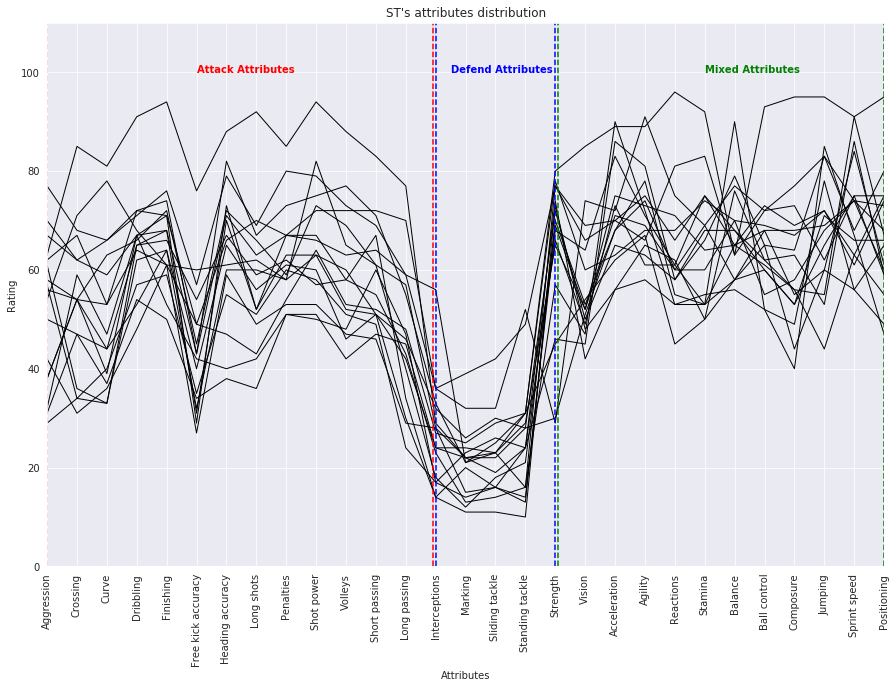

In [11]:
fig, ax = plt.subplots()
df_new_ST = df_new[df_new['Preferred Positions'] == 'ST'].iloc[::200,:-1]
df_new_ST.T.plot.line(color = 'black', figsize = (15,10), legend = False, ylim = (0, 110), title = "ST's attributes distribution", ax=ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation=90)

for ln in ax.lines:
    ln.set_linewidth(1)

ax.axvline(0, color='red', linestyle='--')   
ax.axvline(12.9, color='red', linestyle='--')

ax.axvline(13, color='blue', linestyle='--')
ax.axvline(17, color='blue', linestyle='--')

ax.axvline(17.1, color='green', linestyle='--')
ax.axvline(28, color='green', linestyle='--')

ax.text(5, 100, 'Attack Attributes', color = 'red', weight = 'bold')
ax.text(13.5, 100, 'Defend Attributes', color = 'blue', weight = 'bold')
ax.text(22, 100, 'Mixed Attributes', color = 'green', weight = 'bold')

The pattern is quite obvious, but some outliers are found. It is because some of the players are extremely good at their positions and some of them aren't. But I believe most of them should follow the similar pattern if we have normalized them, for the same position. Let's try it out:

Text(22, 0.07, 'Mixed Attributes')

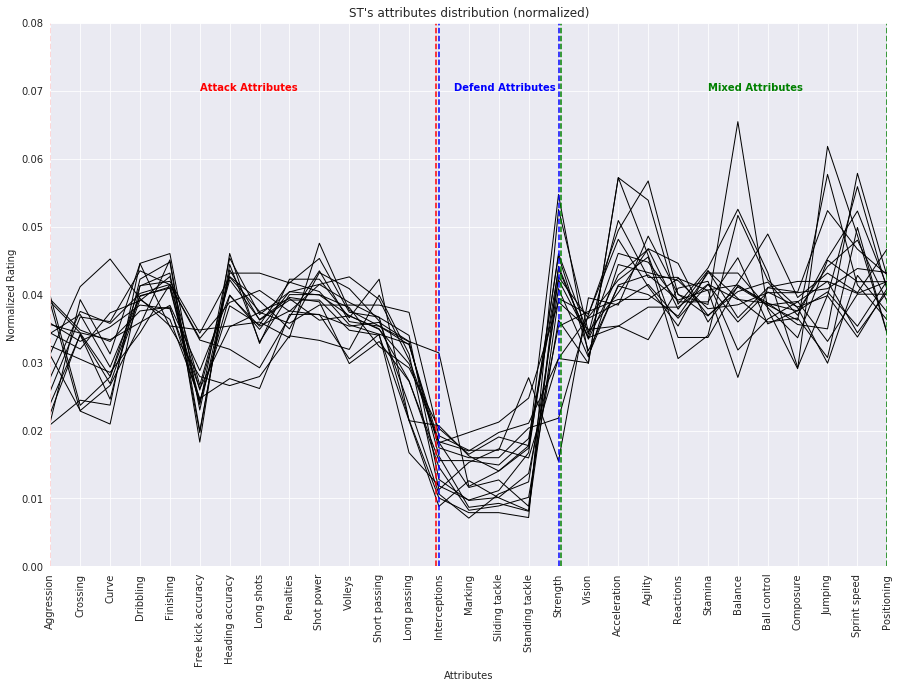

In [12]:
df_new_ST_normalized = df_new_ST.div(df_new_ST.sum(axis=1), axis=0)

fig, ax = plt.subplots()
df_new_ST_normalized.T.plot.line(color = 'black', figsize = (15,10), ylim = (0, 0.08), legend = False, title = "ST's attributes distribution (normalized)", ax=ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Normalized Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation=90)

for ln in ax.lines:
    ln.set_linewidth(1)

ax.axvline(0, color='red', linestyle='--')   
ax.axvline(12.9, color='red', linestyle='--')

ax.axvline(13, color='blue', linestyle='--')
ax.axvline(17, color='blue', linestyle='--')

ax.axvline(17.1, color='green', linestyle='--')
ax.axvline(28, color='green', linestyle='--')

ax.text(5, 0.07, 'Attack Attributes', color = 'red', weight = 'bold')
ax.text(13.5, 0.07, 'Defend Attributes', color = 'blue', weight = 'bold')
ax.text(22, 0.07, 'Mixed Attributes', color = 'green', weight = 'bold') 


## Predict binary targets (attack vs defend positions) with logistic regression

The pattern after normalization looks much more obvious. Lets do below:

* Normalize the whole dataset


* Reclassify the target value (preferred positions) to binary groups as below:
- 1 =  attack positions = ST, RW, LW, RM, CM, LM, CAM, CF 
- 0 = defend positions = CDM, CB, LB, RB, RWB, LWB



In [13]:
df_new_normalized = df_new.iloc[:,:-1].div(df_new.iloc[:,:-1].sum(axis=1), axis=0)
mapping = {'ST': 1, 'RW': 1, 'LW': 1, 'RM': 1, 'CM': 1, 'LM': 1, 'CAM': 1, 'CF': 1, 'CDM': 0, 'CB': 0, 'LB': 0, 'RB': 0, 'RWB': 0, 'LWB': 0}
df_new_normalized['Preferred Positions'] = df_new['Preferred Positions']
df_new_normalized = df_new_normalized.replace({'Preferred Positions': mapping})

df_new_normalized.iloc[::1000,]


,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,Volleys,Short passing,Long passing,Interceptions,Marking,Sliding tackle,Standing tackle,Strength,Vision,Acceleration,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,0.027815,0.037528,0.035762,0.040177,0.041501,0.033554,0.038852,0.040618,0.037528,0.041501,0.038852,0.036645,0.033996,0.012804,0.009713,0.010155,0.013687,0.035320,0.037528,0.039294,0.039294,0.042384,0.040618,0.027815,0.041060,0.041943,0.041943,0.040177,0.041943,1
1000,0.039282,0.034792,0.033109,0.037598,0.038159,0.024130,0.039843,0.035354,0.037598,0.037037,0.035354,0.035915,0.033109,0.031425,0.011785,0.014029,0.017396,0.043771,0.033670,0.035354,0.038159,0.038159,0.041526,0.039282,0.038721,0.037598,0.040404,0.035354,0.042088,1
2000,0.021291,0.039255,0.031271,0.044578,0.035263,0.027944,0.026613,0.027944,0.033932,0.033267,0.031936,0.039920,0.031271,0.011311,0.015303,0.017299,0.015968,0.030605,0.029940,0.057219,0.053892,0.038589,0.043912,0.052562,0.043247,0.029275,0.039920,0.055888,0.040585,1
3000,0.031065,0.022929,0.026627,0.035503,0.045118,0.019970,0.043639,0.036243,0.039201,0.039201,0.034763,0.034024,0.021450,0.020710,0.016272,0.014053,0.017751,0.054734,0.031065,0.041420,0.042899,0.039201,0.040680,0.041420,0.038462,0.036243,0.057692,0.041420,0.036243,1
4000,0.027009,0.038867,0.025033,0.040184,0.037549,0.023715,0.038208,0.034256,0.037549,0.038867,0.029644,0.037549,0.019763,0.017128,0.014493,0.013175,0.012516,0.048748,0.035573,0.052042,0.046113,0.042819,0.047431,0.045455,0.038208,0.032279,0.035573,0.050725,0.039526,1
5000,0.022193,0.030679,0.037859,0.039164,0.030026,0.035901,0.035901,0.035248,0.041123,0.045692,0.043734,0.031332,0.024804,0.008486,0.011097,0.011097,0.011097,0.037206,0.032637,0.049608,0.048303,0.037859,0.050261,0.040470,0.038512,0.037859,0.033290,0.051567,0.046997,1
6000,0.036757,0.031351,0.030811,0.035676,0.029189,0.031351,0.025946,0.034595,0.037297,0.036757,0.026486,0.038919,0.037838,0.035135,0.036757,0.034054,0.036216,0.037297,0.036757,0.024324,0.036757,0.038919,0.037297,0.039459,0.037838,0.041622,0.039459,0.022703,0.032432,0
7000,0.035219,0.038106,0.032333,0.036374,0.034642,0.020208,0.034065,0.031755,0.037529,0.031755,0.029446,0.036952,0.036374,0.031755,0.025982,0.033487,0.036952,0.036952,0.035219,0.038106,0.035219,0.034642,0.037529,0.033487,0.038684,0.032910,0.038106,0.038106,0.038106,0
8000,0.039876,0.027447,0.024858,0.033143,0.033661,0.023822,0.035733,0.033143,0.025893,0.039876,0.029001,0.040911,0.033143,0.040394,0.038840,0.039358,0.041947,0.042983,0.035215,0.030036,0.026929,0.037286,0.041947,0.029518,0.039358,0.034697,0.038322,0.032108,0.030554,0
9000,0.046556,0.036352,0.017857,0.036990,0.014031,0.026786,0.043367,0.028061,0.039541,0.039541,0.013393,0.041454,0.040179,0.045918,0.045918,0.041454,0.044643,0.049745,0.033801,0.032526,0.024872,0.043367,0.024235,0.027423,0.037628,0.038903,0.036352,0.021046,0.028061,0


Split train test dataset:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_new_normalized.iloc[:,:-1], df_new_normalized.iloc[:,-1], random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))


X train shape: (20438, 29)
X test shape: (6813, 29)
y train shape: (20438,)
y test shape: (6813,)


Apply logistic regression to training set:

In [15]:
clf_d = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
acc_d = clf_d.score(X_test, y_test)
print ('Dummy Classifier (most frequent class): {}'.format(acc_d))

clf = LogisticRegression().fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Logistic Regression Accuracy: {}'.format(acc))


Dummy Classifier (most frequent class): 0.6054601497137825
Logistic Regression Accuracy: 0.8586525759577279


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Feature selections

Can we further improve the model accuracy by looking at feature importance?

In [16]:
Coef_list = list(sorted(zip(X_train.columns, abs(clf.coef_[0])),key=lambda x: -x[1]))
Coef_table = pd.DataFrame(np.array(Coef_list).reshape(-1,2), columns = ['Attributes', 'Coef'])

print (Coef_table)

            Attributes                Coef
0              Marking  21.866601914897124
1       Sliding tackle   20.66265513244451
2      Standing tackle  20.176464759992935
3        Interceptions   18.82812389583993
4            Finishing   15.59099153949557
5          Positioning  11.082767833990326
6              Volleys  10.455811059181812
7           Long shots    9.67585770009974
8           Aggression   8.927628494646891
9               Vision   8.663929820497378
10           Dribbling   7.854538550625115
11           Penalties   7.508758791661603
12            Strength   7.111915161679565
13    Heading accuracy   5.920784979967218
14          Shot power  5.7389397963407776
15               Curve   5.679811331202898
16             Agility  5.6442399967092705
17  Free kick accuracy  5.3630163652966525
18             Jumping   4.889554440739089
19        Ball control   4.643909701058903
20             Balance    4.43912518300854
21        Acceleration  3.6378922503635054
22         

Let's try limit the features to top 10 only:

In [17]:
target_cols = Coef_table[:10]['Attributes'].tolist()

clf_2 = LogisticRegression().fit(X_train[target_cols], y_train)
acc_2 = clf_2.score(X_test[target_cols], y_test)
print ('Logistic Regression Accuracy (10 features): {}'.format(acc_2))

Logistic Regression Accuracy (10 features): 0.8605606927931895


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy is slightly improved. Another interesting observation is **positioning** attribute is quite significant in the model and probably should not be classified under *mix* attributes, while some *attack* attributes like **crossing** is not that significant (probably because LB / RB have high crossing ratings too)

Another interesting observation is that the most significant attributes are mostly defensive ones, meaning that they are most helpful to help us identify the role of a player. In other words, it is extremely rare for a player in an attacking role like ST to be good at those defensive skills, while it is relatively easier for a player in a defensive role to be good at some attacking skills like crossing and free kick accuracy, etc.

## Study PCA impact on model accuracy

Reviewing the whole project again, I would think some of the attributes are quite related to others and therefore I can make use of some dimension reduction technique (namely PCA), I reference this [article](https://www.kaggle.com/arthurtok/principal-component-analysis-with-kmeans-visuals) from [Anisotropic](https://www.kaggle.com/arthurtok) for helping me to implement the model. Let's look at heatmap first:

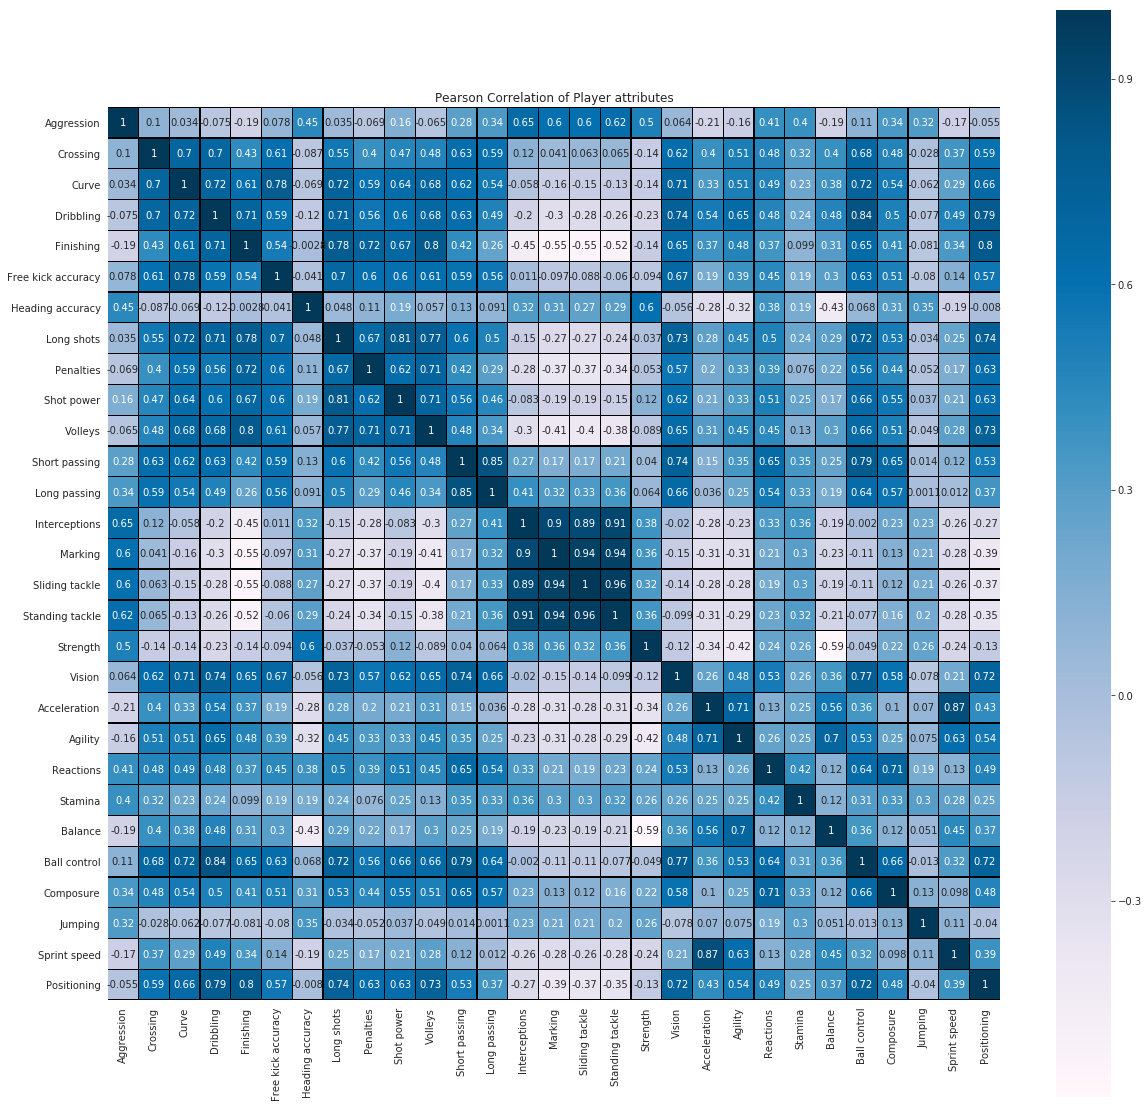

In [18]:
f, ax = plt.subplots(figsize=(20, 20))

plt.title('Pearson Correlation of Player attributes')

sns.heatmap(df_new.corr(),linewidths=0.25,vmax=1.0, square=True, cmap = 'PuBu', linecolor='black', annot=True)

Let's find the reasonable number of component of PCA *(I re-used most codes from above article and only modify to suit my needs)*:

[(0, 39.16353634511586), (1, 65.96184889111241), (2, 73.57259182489241), (3, 78.45692192840906), (4, 80.64731458634051), (5, 82.58891562917903), (6, 84.28743585426042), (7, 85.9069401085956), (8, 87.31349452187553), (9, 88.57751241668728), (10, 89.73399064195067), (11, 90.71460036879185), (12, 91.62877381693554), (13, 92.48020328428922), (14, 93.2788934587032), (15, 94.03989683967822), (16, 94.75345403627703), (17, 95.43913340990223), (18, 96.05888520637772), (19, 96.64497534326223), (20, 97.19623346873271), (21, 97.7228047588172), (22, 98.21792304917685), (23, 98.63407112172794), (24, 99.0257793524714), (25, 99.31213932733301), (26, 99.5815217730476), (27, 99.81726237754016), (28, 100.00000000000001)]


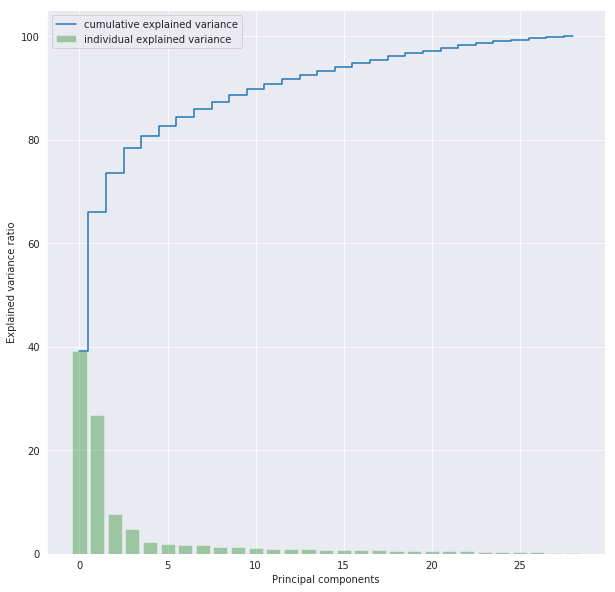

In [19]:
cov_mat = np.cov(df_new.iloc[:,:-1].T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

print(list(zip(range(29),cum_var_exp)))

# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 10))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()


17 components are needed for 95%+ of variance level:

In [20]:
pca = PCA(n_components=17)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_new.iloc[:,:-1], df_new.iloc[:,-1], random_state=0)

X_train_2_pca = pca.fit_transform(X_train_2)
X_train_2_pca = pd.DataFrame(X_train_2_pca)

x_test_2_pca = pca.transform(X_test_2)

clf_17d = LogisticRegression().fit(X_train_2_pca, y_train_2)
acc_17d = clf_17d.score(x_test_2_pca, y_test_2)
print ('Logistic Regression Accuracy with PCA (17 components): {}'.format(acc_17d))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression Accuracy with PCA (17 components): 0.4410685454278585


PCA reduced the performance of our logistic regression model performance. Why is that? I did some research online and found some good explanation [here](https://stackoverflow.com/questions/36668768/why-did-pca-reduced-the-performance-of-logistic-regression)

## Study LDA impact on model accuracy

While PCA ignores class label, LDA takes into consideration of class label to computes the directions (“linear discriminants”) that will represent the axes that that maximize the separation between multiple classes. More detailed explanation can be find [here](http://sebastianraschka.com/Articles/2014_python_lda.html#principal-component-analysis-vs-linear-discriminant-analysis).

Let's see how it is implemented:

In [21]:
lda = LDA(n_components=None)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_new.iloc[:,:-1], df_new.iloc[:,-1], random_state=0)

X_lda = lda.fit(X_train_3, y_train_3)

lda_var_ratios = lda.explained_variance_ratio_

# get number of components needed to explain 95% variance
def select_n_components(var_ratio, goal_var: float) -> int:
    
    total_variance = 0.0
    n_components = 0
    
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        if total_variance >= goal_var:
            break

    return n_components

print('Number of components needed to explain 95% variance: {}'.format(select_n_components(lda_var_ratios, 0.95)))

Number of components needed to explain 95% variance: 3


In [22]:
lda_n = LDA(n_components=3)
X_train_3_lda = lda_n.fit_transform(X_train_3, y_train_3)
X_train_3_lda = pd.DataFrame(X_train_3_lda)

X_test_3_lda = lda_n.transform(X_test_3)

clf_3d = LogisticRegression().fit(X_train_3_lda, y_train_3)
acc_3d = clf_3d.score(X_test_3_lda, y_test_3)
print ('Logistic Regression Accuracy with LDA (3 components): {}'.format(acc_3d))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression Accuracy with LDA (3 components): 0.4299134008513137


## Predict all positions (14 targets) with logistic regression

Now let's try to predict all positions (14 targets, e.g. ST, LW, etc) with logistic regression. First we need to prepare to data:

In [23]:
df_new_normalized_all = df_new.copy()
mapping_all = {'ST': 0, 'RW': 1, 'LW': 2, 'RM': 3, 'CM': 4, 'LM': 5, 'CAM': 6, 'CF': 7, 'CDM': 8, 'CB': 9, 'LB': 10, 'RB': 11, 'RWB': 12, 'LWB': 13}

df_new_normalized_all = df_new_normalized_all.replace({'Preferred Positions': mapping_all})
df_new_normalized_all.iloc[::1000,]


,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,Volleys,Short passing,Long passing,Interceptions,Marking,Sliding tackle,Standing tackle,Strength,Vision,Acceleration,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,88,83,77,29,22,23,31,80,85,89,89,96,92,63,93,95,95,91,95,0
1000,70,62,59,67,68,43,71,63,67,66,63,64,59,56,21,25,31,78,60,63,68,68,74,70,69,67,72,63,75,0
2000,32,59,47,67,53,42,40,42,51,50,48,60,47,17,23,26,24,46,45,86,81,58,66,79,65,44,60,84,61,0
3000,42,31,36,48,61,27,59,49,53,53,47,46,29,28,22,19,24,74,42,56,58,53,55,56,52,49,78,56,49,0
4000,41,59,38,61,57,36,58,52,57,59,45,57,30,26,22,20,19,74,54,79,70,65,72,69,58,49,54,77,60,1
5000,34,47,58,60,46,55,55,54,63,70,67,48,38,13,17,17,17,57,50,76,74,58,77,62,59,58,51,79,72,2
6000,68,58,57,66,54,58,48,64,69,68,49,72,70,65,68,63,67,69,68,45,68,72,69,73,70,77,73,42,60,8
7000,61,66,56,63,60,35,59,55,65,55,51,64,63,55,45,58,64,64,61,66,61,60,65,58,67,57,66,66,66,8
8000,77,53,48,64,65,46,69,64,50,77,56,79,64,78,75,76,81,83,68,58,52,72,81,57,76,67,74,62,59,9
9000,73,57,28,58,22,42,68,44,62,62,21,65,63,72,72,65,70,78,53,51,39,68,38,43,59,61,57,33,44,9


Fit the model:

In [24]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_new_normalized_all.iloc[:,:-1], df_new_normalized_all.iloc[:,-1], random_state=0)

print('X train shape: {}'.format(X_train_all.shape))
print('X test shape: {}'.format(X_test_all.shape))
print('y train shape: {}'.format(y_train_all.shape))
print('y test shape: {}'.format(y_test_all.shape))

X train shape: (20438, 29)
X test shape: (6813, 29)
y train shape: (20438,)
y test shape: (6813,)


In [25]:
clf_d_all = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
acc_d_all = clf_d_all.score(X_test, y_test)
print ('Dummy Classifier (most frequent class): {}'.format(acc_d_all))

clf_all = LogisticRegression().fit(X_train, y_train)
acc_all = clf_all.score(X_test, y_test)
print ('Logistic Regression Accuracy: {}'.format(acc_all))

Dummy Classifier (most frequent class): 0.6054601497137825
Logistic Regression Accuracy: 0.8586525759577279


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Predict all positions (14 targets) with random forest

The accuracy significantly drops when we tried to classify 14 targets instead of 2. Let's try out other model, Random forest:

In [26]:
clf_all_for = RandomForestClassifier(random_state=0).fit(X_train, y_train)
acc_all_for = clf_all_for.score(X_test, y_test)
print ('Random Forest Accuracy (Default parameters): {}'.format(acc_all_for))


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Accuracy (Default parameters): 0.7920152649346837


Accuracy isn't satisfying, let's try use gridsearchcv to find better parameters to the model:

In [27]:
# parameters_f = [{'max_depth': range(2,10), 'n_estimators': range(2,8,2), 'max_features': range(10,20)}]
parameters_f = [{'max_depth': range(5,8,15), 'n_estimators': range(1,10,100), "min_samples_leaf" : [1, 2, 4]}]
clf_all_for_g = GridSearchCV(RandomForestClassifier(random_state=0), parameters_f)
clf_all_for_g.fit(X_train, y_train)

print('Best score for train data:', clf_all_for_g.best_score_)
print('Best depth:',clf_all_for_g.best_estimator_.max_depth)
print('Best n trees:',clf_all_for_g.best_estimator_.n_estimators)
print('Best n features:',clf_all_for_g.best_estimator_.max_features)
print('Score for test data:',clf_all_for_g.score(X_test, y_test))



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best score for train data: 0.8556610235835209
Best depth: 5
Best n trees: 1
Best n features: auto
Score for test data: 0.8489652135623074


## Predict all positions (14 targets) with neural networks

Let's look at neural networks and parameters:

In [28]:
clf_all_nn = MLPClassifier(random_state=0).fit(X_train, y_train)
acc_all_nn = clf_all_nn.score(X_test, y_test)
print ('Neural Networks Accuracy (Default parameters): {}'.format(acc_all_nn))

parameters_n = [{'alpha': [0.0001, 0.001, 0.01, 0.1], 'hidden_layer_sizes':[(10,),(20,),(100,),(200,)]}]
clf_all_nn_g = GridSearchCV(MLPClassifier(random_state=0), parameters_n)
clf_all_nn_g.fit(X_train, y_train)

print('Best score for train data:', clf_all_nn_g.best_score_)
print('Best alpha:',clf_all_nn_g.best_estimator_.alpha)
print('Best hidden_layer_sizes:',clf_all_nn_g.best_estimator_.hidden_layer_sizes)
print('Score for test data:',clf_all_nn_g.score(X_test, y_test))


NameError: ignored

Neural Networks Accuracy (Default parameters): 0.8659914868633495


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

Best score for train data: 0.8675995694294941
Best alpha: 0.01
Best hidden_layer_sizes: (200,)
Score for test data: 0.863789813591663


Accuracy improves but is not very high. This may be due to the fact that many players have mixed attributes, like ST / LW / RW may process very similar pattern in attributes. We might need more other signficant features in this case.

## Evaluate the Models

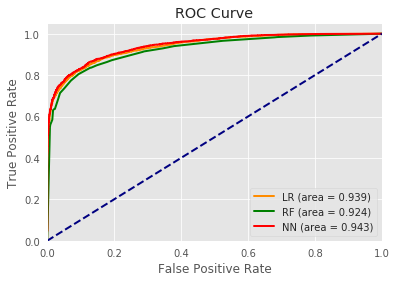

In [33]:
plt.style.use('ggplot')
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure()

y1_test=y_test[(y_test ==0) | (y_test ==1)]
x1_test = X_test[X_test.index.isin(y1_test.index)]

#ROC Curve of Logistic Regression
y_predict_probabilities = clf_all.predict_proba(x1_test)[:,1]
fpr, tpr, _ = roc_curve(y1_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='LR (area = %0.3f)' % roc_auc)

#ROC Curve of Random Forest
y_predict_probabilities = clf_all_for_g.predict_proba(x1_test)[:,1]
fpr, tpr, _ = roc_curve(y1_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',
         lw=2, label='RF (area = %0.3f)' % roc_auc)

#ROC Curve of Neural Network
y_predict_probabilities = clf_all_nn_g.predict_proba(x1_test)[:,1]
fpr, tpr, _ = roc_curve(y1_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',
         lw=2, label='NN (area = %0.3f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()